In [1]:
import picamera
import time
from IPython.display import Image
import math
import serial
import re
import cv2 as cv

In [2]:
IMAGES_PATH = "images/"
utils = "Utils/"

bottle_cascade = cv.CascadeClassifier(utils + 'haar_bottle.xml')

In [666]:
''''''
''' TCP COMMUNICATION '''
''''''

def enable_tcp_com(BUFFER_SIZE):
    TCP_IP = '192.168.0.21' 
    TCP_PORT = 5005
    while(1):
        try:
            s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            s.connect((TCP_IP, TCP_PORT))
            s.setblocking(0)
        except:
            continue
        else:
            print("TCP com enabled!")
            break

    return s

def send_message(s, msg):
    s.send((msg).encode())
    
def check_data_received(s, msg, BUFFER_SIZE):
    ready = select.select([s], [], [], 0.2)
    print(ready)
    if ready[0]:
        data = s.recv(BUFFER_SIZE)
        print(data.decode())
        return data.decode()[-9:] == msg
    else :
        print("Data was not received")
        return None

def close_connection(s):
    s.close()

''''''
''' Robot position '''
''''''


def open_ser():
    ser = serial.Serial(
        port='../../../dev/ttyS0', #Replace ttyS0 with ttyAM0 for Pi1,Pi2,Pi0
        baudrate = 115200,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        bytesize=serial.EIGHTBITS,
        timeout=1
    )
    return ser

def get_robot_pos_angle(ser):
    buffer = ''
    ser.flushInput()
    time.sleep(0.1)
    timeout = time.time() + 5 #5s timeout
    while True:
        # last_received = ser.readline()
        buffer += str(ser.read(ser.inWaiting()))
        
        if len(buffer.split('\\n')) >= 3:
            last_received = buffer.split('\\n')[-2]
            pos_angle = re.findall('[+-]?\d+\.\d+', last_received )
            if len(pos_angle) == 3:
                return pos_angle[0], pos_angle[1], pos_angle[2]
        if time.time() > timeout:
            return -1, -1, -1
            break


''''''
''' Bottle position '''
''''''

def calcul_bottle_pos(xr,yr,ar,dist_rb,a_rb):
    ar = ar - 90
    ar = ar % 360
    
    ab = ar + a_rb
            
    rel_xb = dist_rb * math.sin(math.radians(ab))
    rel_yb = dist_rb * math.cos(math.radians(ab))
    
    real_xb = xr + rel_xb
    real_yb = yr + rel_yb
    return real_xb,real_yb


def calcul_low_center(x,y,w,h):
    return (x+w/2), (y+h)

def multiDimenDist(point1,point2):
   #find the difference between the two points, its really the same as below
    deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
    runningSquared = 0
   #because the pythagarom theorm works for any dimension we can just use that
    for coOrd in deltaVals:
        runningSquared += coOrd**2
    return runningSquared**(1/2)
def findVec(point1,point2,unitSphere = False):
    #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
    finalVector = [0 for coOrd in point1]
    for dimension, coOrd in enumerate(point1):
        #finding total differnce for that co-ordinate(x,y,z...)
        deltaCoOrd = point2[dimension]-coOrd
        #adding total difference
        finalVector[dimension] = deltaCoOrd
    if unitSphere:
        totalDist = multiDimenDist(point1,point2)
        unitVector =[]
        for dimen in finalVector:
            unitVector.append( dimen/totalDist)
            return unitVector
    else:
        return finalVector

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def calcul_angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def calcul_bottle_dist_angle(center, img_width, img_height):
    vect1 = findVec([img_width/2, img_height],[img_width/2, 0])
    vect2 = findVec([img_width/2, img_height],[center[0],center[1]])
    angle_br = math.degrees(calcul_angle(vect1,vect2))
    if center[0] > img_width/2:
        angle_br = -angle_br
    dist = 20546*(center[1]**-1.279)
    return dist, angle_br

# Main

In [4]:
camera = picamera.PiCamera()
camera.rotation = 180

BUFFER_SIZE = 1024
#s = enable_tcp_com(BUFFER_SIZE)
#ser = open_ser()

In [4]:
ser = open_ser()

In [10]:
get_robot_pos_angle(ser)

('21.90', '149.45', '49.71')

In [ ]:
camera.capture(IMAGES_PATH + "cam.bmp")
img = cv.imread(IMAGES_PATH + 'cam.bmp')

# resize to increase speed detection
rows,cols = img.shape[:2]   
img = cv.resize(img,(round(cols*0.7),round(rows*0.7)))

bottles = face_cascade.detectMultiScale(img)
cv.imwrite(IMAGES_PATH + "before_haar.png", img)

bottle_x = []
bottle_y = []
i = 0
tcp_msg = ""
for (x,y,w,h) in bottles:
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    robot_x, robot_y, robot_a = get_robot_pos_angle(ser)
    bottle_dist, bottle_a = calcul_bottle_dist_angle(x,y,w,h)
    bottle_x[i], bottle_y[i] = calcul_bottle_pos(robot_x, robot_y, robot_a, bottle_dist, bottle_a)
    tcp_msg = tcp_msg + "(" + bottle_x[i] + "," + bottle_y[i] + ");"
    i = i +1

send_message(s, tcp_msg )

print(bottle_x)
print(bottle_y)
    
cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

# Haar test

In [679]:
camera.capture(IMAGES_PATH + "cam.bmp")
img = cv.imread(IMAGES_PATH + 'cam.bmp')

In [680]:
# resize to increase speed detection
rows,cols = img.shape[:2]   
img = cv.resize(img,(round(cols*0.7),round(rows*0.7)))

In [681]:
img_height, img_width = img.shape[:2] 
img.shape[:2] 
print("({},{})".format(img_width,img_height))

(504,336)


time: 0.38212156295776367
0 angle: 10.124671655397842
0 dist: 172.4215088902309
(199.5, 42)
1 angle: 24.179107146689173
1 dist: 18.75363053395402
(208.0, 238)
2 angle: 18.833752912658856
2 dist: 22.418224396131823
(208.0, 207)
3 angle: 34.99202019855866
3 dist: 15.88398838247948
(206.5, 271)
4 angle: 69.92847413546127
4 dist: 12.997878930887955
(200.0, 317)
5 angle: 7.458127592823126
5 dist: 106.9770025046987
(216.0, 61)
6 angle: 7.070344820157548
6 dist: 78.11569245945115
(220.0, 78)


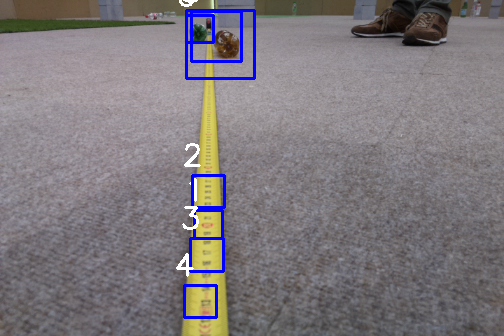

In [682]:
start_time = time.time()
bottles = bottle_cascade.detectMultiScale(img, minNeighbors=1)
print("time: " + str(time.time() - start_time))
i = 0
for (x,y,w,h) in bottles:
    font = cv.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (x-10,y-10)
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2
    cv.putText(img,str(i), bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
    center = calcul_low_center(x,y,w,h)
    dist, angle = calcul_bottle_dist_angle(center, img_width, img_height)
    print(str(i) + " angle: " + str(angle))
    print(str(i) + " dist: " + str(dist))
    print(center)
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    i = i + 1

cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

# Serial test

In [4]:
ser = open_ser()

In [130]:
start_time = time.time()
x, y, angle = get_robot_pos_angle(ser)
end_time = time.time()
print(str(end_time - start_time))
print(str(x) + " " + str(y) + " " + str(angle))

0.10181117057800293
712.17 -92.30 -13.06


In [19]:
camera.close()